### Libraries

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Data-Preprocessing

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. DATA LOADING AND EXPLORATION
# Load the data from URL
url = "https://docs.google.com/spreadsheets/d/1AYRqWP4AjJzR4TaERFq9XF2fiZi4tKOVyCUCYkuY3QQ/export?format=csv"
df = pd.read_csv(url)

# Display information about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cement                      1030 non-null   float64
 1   Slag                        1030 non-null   float64
 2   Fly Ash                     1030 non-null   float64
 3   Water                       1030 non-null   float64
 4   Superplasticizer            1030 non-null   float64
 5   Coarse Aggregate            1030 non-null   float64
 6   Fine Aggregate              1030 non-null   float64
 7   Age (day)                   1030 non-null   int64  
 8   Compressive strength (MPa)  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [4]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   Cement   Slag  Fly Ash  Water  Superplasticizer  Coarse Aggregate  \
0   540.0    0.0      0.0  162.0               2.5            1040.0   
1   540.0    0.0      0.0  162.0               2.5            1055.0   
2   332.5  142.5      0.0  228.0               0.0             932.0   
3   332.5  142.5      0.0  228.0               0.0             932.0   
4   198.6  132.4      0.0  192.0               0.0             978.4   

   Fine Aggregate  Age (day)  Compressive strength (MPa)  
0           676.0         28                       79.99  
1           676.0         28                       61.89  
2           594.0        270                       40.27  
3           594.0        365                       41.05  
4           825.5        360                       44.30  


In [5]:
# Find the target column (the one with 'compressive strength' in the name)
target_column = None
for col in df.columns:
    if 'compressive strength' in col.lower():
        target_column = col
        print(f"\nTarget column identified: {target_column}")
        break

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Target column identified: Compressive strength (MPa)

Missing Values:
Cement                        0
Slag                          0
Fly Ash                       0
Water                         0
Superplasticizer              0
Coarse Aggregate              0
Fine Aggregate                0
Age (day)                     0
Compressive strength (MPa)    0
dtype: int64


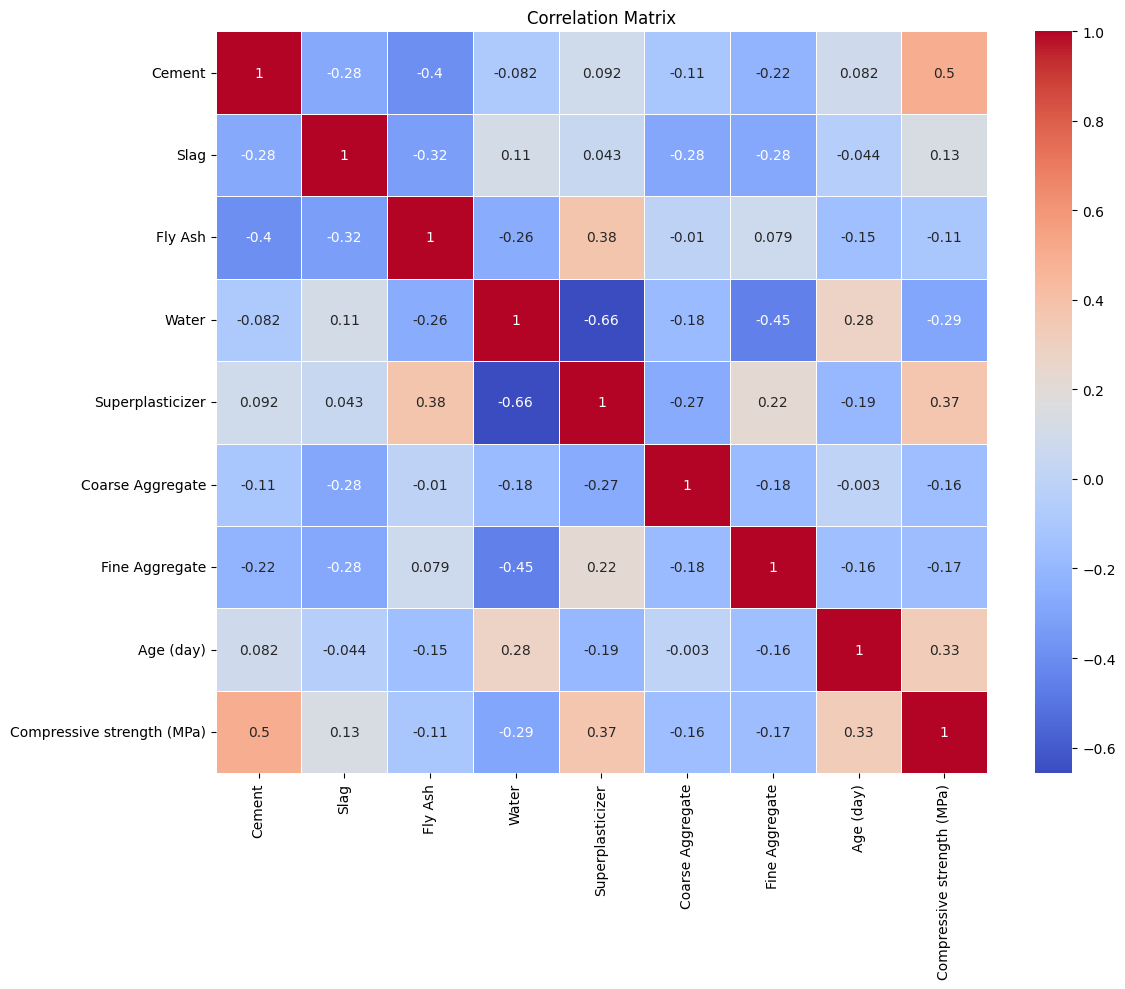

In [6]:
# Explore relationships between features and target
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [7]:
# Separate features and target
X = df.drop(target_column, axis=1)
y = df[target_column]

# Split the data into training, validation, and test sets (70%-15%-15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42) # 0.176 of 85% is ~15% of the total

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (721, 8)
Validation set size: (154, 8)
Test set size: (155, 8)


### Model-Traning

In [8]:
# 3. BASELINE ANN MODEL
def create_baseline_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Create and train baseline model
baseline_model = create_baseline_model(X_train_scaled.shape[1])
print("\nBaseline Model Summary:")
baseline_model.summary()

# Set up callbacks for early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

# Train the baseline model
baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate baseline model
baseline_loss = baseline_model.evaluate(X_test_scaled, y_test)
baseline_mse = baseline_loss[0]
baseline_mae = baseline_loss[1]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Baseline Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 1460.3323 - mae: 34.7885 - val_loss: 1542.2897 - val_mae: 34.9356
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1379.5265 - mae: 33.6840 - val_loss: 1442.6569 - val_mae: 33.5816
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1268.9283 - mae: 32.1065 - val_loss: 1278.5615 - val_mae: 31.2402
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1091.2764 - mae: 29.4041 - val_loss: 1036.1855 - val_mae: 27.4537
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 843.4203 - mae: 25.1739 - val_loss: 738.6605 - val_mae: 22.1246
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 565.9774 - mae: 19.7082 - val_loss: 462.6625 - val_mae: 16.6902
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 346.3412 - mae: 14.7423 - val_loss: 292.5836 - val_mae: 13.3650
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 241.1849 - mae: 12.2997 - val_loss: 226.0806 - val_mae: 11.9901
Epo

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


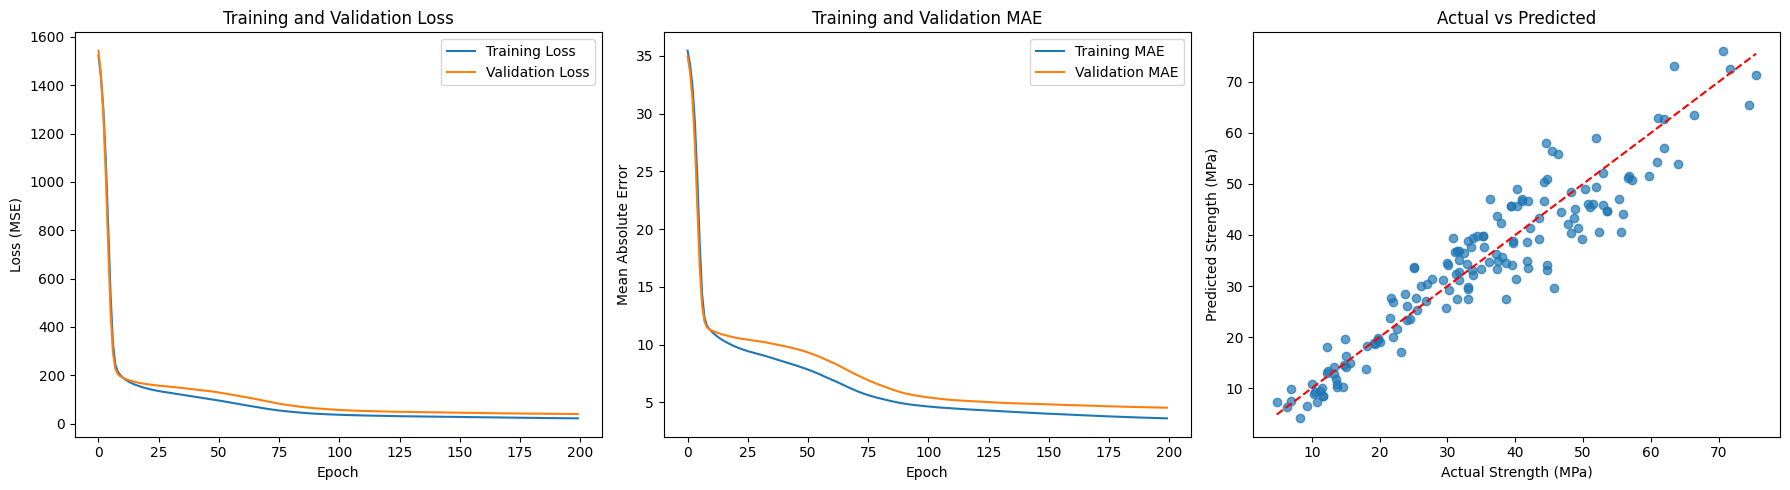

In [9]:
# Plot training history and predictions in a single row
plt.figure(figsize=(18, 5))

# Training and Validation Loss plot
plt.subplot(1, 3, 1)
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Training and Validation MAE plot
plt.subplot(1, 3, 2)
plt.plot(baseline_history.history['mae'], label='Training MAE')
plt.plot(baseline_history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Predictions vs Actual Values plot
plt.subplot(1, 3, 3)
baseline_predictions = baseline_model.predict(X_test_scaled).flatten()
plt.scatter(y_test, baseline_predictions, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Strength (MPa)')
plt.ylabel('Predicted Strength (MPa)')

# Add space between subplots and save
plt.tight_layout()
plt.show()

In [10]:
# Calculate baseline R-squared
baseline_r2 = r2_score(y_test, baseline_predictions)
print(f"Baseline Model - Test MSE: {baseline_mse:.4f}")
print(f"Baseline Model - Test MAE: {baseline_mae:.4f}")
print(f"Baseline Model R²: {baseline_r2:.4f}")

Baseline Model - Test MSE: 30.1271
Baseline Model - Test MAE: 4.3357
Baseline Model R²: 0.8849


### HYPERPARAMETER OPTIMIZATION

In [11]:
# Define different learning rate schedules
def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 20
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

def exponential_decay(epoch):
    initial_lr = 0.001
    k = 0.1
    lr = initial_lr * math.exp(-k * epoch)
    return lr

def cosine_annealing(epoch):
    initial_lr = 0.001
    min_lr = 0.00001
    max_epochs = 200
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(math.pi * epoch / max_epochs)) / 2

# Create model variations for hyperparameter optimization
def create_model(n_layers, n_neurons, activation, optimizer_name, lr=0.001):
    model = Sequential()

    # Input layer
    model.add(Dense(n_neurons[0], activation=activation, input_dim=X_train_scaled.shape[1]))

    # Hidden layers
    for i in range(1, n_layers):
        model.add(Dense(n_neurons[i], activation=activation))
        model.add(Dropout(0.2))  # Add dropout for regularization

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Set optimizer
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=lr, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [12]:
# Define hyperparameter combinations to try (reduced for demonstration)
hyperparameter_combinations = [
    # n_layers, n_neurons, activation, optimizer_name, lr_schedule
    (2, [64, 32], 'relu', 'adam', None),
    (3, [128, 64, 32], 'relu', 'adam', None),
    (3, [128, 64, 32], 'tanh', 'adam', None),
    (3, [128, 64, 32], 'relu', 'sgd', None),
    (3, [128, 64, 32], 'relu', 'adam', 'step'),
    (3, [128, 64, 32], 'relu', 'adam', 'cosine')
]

# Train and evaluate different models
model_results = []

for i, (n_layers, n_neurons, activation, optimizer_name, lr_schedule) in enumerate(hyperparameter_combinations):
    print(f"\nTraining Model {i+1}/{len(hyperparameter_combinations)}")
    print(f"Configuration: layers={n_layers}, neurons={n_neurons}, activation={activation}, optimizer={optimizer_name}, lr_schedule={lr_schedule}")

    # Create model
    model = create_model(n_layers, n_neurons, activation, optimizer_name)

    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
    ]

    # Add learning rate scheduler if specified
    if lr_schedule == 'step':
        callbacks.append(LearningRateScheduler(step_decay))
    elif lr_schedule == 'exponential':
        callbacks.append(LearningRateScheduler(exponential_decay))
    elif lr_schedule == 'cosine':
        callbacks.append(LearningRateScheduler(cosine_annealing))

    # Train model with different batch sizes (reduced for demonstration)
    batch_sizes = [32, 64]
    batch_results = []

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")
        history = model.fit(
            X_train_scaled, y_train,
            epochs=150,  # Reduced for demonstration
            batch_size=batch_size,
            validation_data=(X_val_scaled, y_val),
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate model
        val_loss = model.evaluate(X_val_scaled, y_val)
        val_mse = val_loss[0]
        val_mae = val_loss[1]
        print(f"Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

        batch_results.append((batch_size, val_mse, val_mae, history))

    # Get best batch size based on validation MSE
    best_batch = min(batch_results, key=lambda x: x[1])

    # Evaluate on test set with best batch size
    test_loss = model.evaluate(X_test_scaled, y_test)
    test_mse = test_loss[0]
    test_mae = test_loss[1]

    # Make predictions and calculate R²
    test_predictions = model.predict(X_test_scaled).flatten()
    test_r2 = r2_score(y_test, test_predictions)

    # Store results
    model_results.append({
        'config': {
            'n_layers': n_layers,
            'n_neurons': n_neurons,
            'activation': activation,
            'optimizer': optimizer_name,
            'lr_schedule': lr_schedule,
            'batch_size': best_batch[0]
        },
        'validation_mse': best_batch[1],
        'validation_mae': best_batch[2],
        'test_mse': test_mse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'history': best_batch[3]
    })

# Identify the best model based on validation MSE
best_model_idx = min(range(len(model_results)), key=lambda i: model_results[i]['validation_mse'])
best_model_config = model_results[best_model_idx]['config']




Training Model 1/6
Configuration: layers=2, neurons=[64, 32], activation=relu, optimizer=adam, lr_schedule=None
Training with batch size: 32
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 1439.9213 - mae: 34.4994 - val_loss: 1476.4850 - val_mae: 33.9985
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1300.6733 - mae: 32.5129 - val_loss: 1300.2758 - val_mae: 31.4142
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1123.6851 - mae: 29.7771 - val_loss: 1050.9010 - val_mae: 27.4447
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 863.3966 - mae: 25.4132 - val_loss: 748.8589 - val_mae: 22.1089
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 577.2224 - mae: 19.8684 - val_loss: 472.6074 - val_mae: 17.0136
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 357.9398 - mae: 15.4227 - val_loss: 303.6087 - val_mae: 13.8697
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 256.0970 - mae: 12.8785 - val_loss: 239.0155 - val_mae: 12.4419
Epoch 8/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 239.3415 - mae: 12.2684 - val_loss: 216.6147 - val_mae: 11.9606
Epoch 9/150
23/23 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 1461.8364 - mae: 34.7452 - val_loss: 1468.1337 - val_mae: 33.7563
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1235.4659 - mae: 31.3490 - val_loss: 948.2618 - val_mae: 25.3841
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 645.3688 - mae: 20.8317 - val_loss: 300.6966 - val_mae: 13.9334
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 307.1333 - mae: 14.0390 - val_loss: 237.3905 - val_mae: 12.5132
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 253.5629 - mae: 12.6610 - val_loss: 214.6980 - val_mae: 12.0066
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 227.4134 - mae: 11.9676 - val_loss: 196.7485 - val_mae: 11.6198
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 212.6536 - mae: 11.4049 - val_loss: 194.8908 - val_mae: 11.5341
Epoch 8/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 206.4431 - mae: 11.3369 - val_loss: 183.9553 - val_mae: 11.2919
Epoch 9/150
23/23 ━━━━━━

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Training Model 3/6
Configuration: layers=3, neurons=[128, 64, 32], activation=tanh, optimizer=adam, lr_schedule=None
Training with batch size: 32
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 1468.8539 - mae: 34.9604 - val_loss: 1538.9180 - val_mae: 35.3417
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1385.1035 - mae: 34.2271 - val_loss: 1386.0487 - val_mae: 33.4877
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1219.0895 - mae: 31.8072 - val_loss: 1155.3721 - val_mae: 29.0896
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 998.2123 - mae: 27.5341 - val_loss: 1046.4700 - val_mae: 26.9124
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 909.8590 - mae: 25.7606 - val_loss: 987.0043 - val_mae: 25.8491
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 855.6064 - mae: 24.7426 - val_loss: 938.6111 - val_mae: 24.9895
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 807.7531 - mae: 23.8565 - val_loss: 895.6772 - val_mae: 24.2057
Epoch 8/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 763.3604 - mae: 23.0773 - val_loss: 856.6598 - val_mae: 23.4736
Epoch 9/150
23/23 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 1164.4092 - mae: 29.5030 - val_loss: 222.4010 - val_mae: 12.2278
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 267.9570 - mae: 12.7208 - val_loss: 429.5847 - val_mae: 15.5281
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 342.2467 - mae: 14.2516 - val_loss: 766.4995 - val_mae: 21.4140
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 477.9753 - mae: 16.2424 - val_loss: 155.5880 - val_mae: 10.0490
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 150.9787 - mae: 9.7142 - val_loss: 129.3520 - val_mae: 8.7842
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.7894 - mae: 10.1337 - val_loss: 107.4426 - val_mae: 7.9704
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 115.3480 - mae: 8.4448 - val_loss: 117.5025 - val_mae: 8.5998
Epoch 8/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 123.9905 - mae: 8.8610 - val_loss: 88.4136 - val_mae: 7.2005
Epoch 9/150
23/23 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 1446.1554 - mae: 34.5281 - val_loss: 1408.7061 - val_mae: 32.9053 - learning_rate: 0.0010
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1153.5646 - mae: 30.0674 - val_loss: 771.4446 - val_mae: 22.2083 - learning_rate: 0.0010
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 478.5335 - mae: 17.5408 - val_loss: 264.5815 - val_mae: 13.0838 - learning_rate: 0.0010
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 258.9636 - mae: 12.7212 - val_loss: 239.1677 - val_mae: 12.5049 - learning_rate: 0.0010
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 240.1954 - mae: 12.4397 - val_loss: 207.8153 - val_mae: 11.8101 - learning_rate: 0.0010
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 212.3141 - mae: 11.6645 - val_loss: 193.5584 - val_mae: 11.4737 - learning_rate: 0.0010
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 197.9169 - mae: 11.1178 - val_loss: 188.6344 - val_mae: 11.3901 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 1453.7761 - mae: 34.6298 - val_loss: 1432.1665 - val_mae: 33.2997 - learning_rate: 0.0010
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1169.8893 - mae: 30.3744 - val_loss: 796.4429 - val_mae: 22.8288 - learning_rate: 9.9994e-04
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 496.6775 - mae: 18.1034 - val_loss: 251.5489 - val_mae: 12.7610 - learning_rate: 9.9976e-04
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 253.1562 - mae: 12.6339 - val_loss: 248.7594 - val_mae: 12.7607 - learning_rate: 9.9945e-04
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 238.6920 - mae: 12.5820 - val_loss: 214.3742 - val_mae: 12.1009 - learning_rate: 9.9902e-04
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 206.8716 - mae: 11.6370 - val_loss: 198.6126 - val_mae: 11.7142 - learning_rate: 9.9847e-04
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 210.6623 - mae: 11.4439 - val_loss: 188.9551 - 

In [13]:
print("\nBest Model Configuration:")
for key, value in best_model_config.items():
    print(f"{key}: {value}")
print(f"Validation MSE: {model_results[best_model_idx]['validation_mse']:.4f}")
print(f"Validation MAE: {model_results[best_model_idx]['validation_mae']:.4f}")
print(f"Test MSE: {model_results[best_model_idx]['test_mse']:.4f}")
print(f"Test MAE: {model_results[best_model_idx]['test_mae']:.4f}")
print(f"Test R²: {model_results[best_model_idx]['test_r2']:.4f}")


Best Model Configuration:
n_layers: 3
n_neurons: [128, 64, 32]
activation: relu
optimizer: sgd
lr_schedule: None
batch_size: 32
Validation MSE: 24.2135
Validation MAE: 3.6112
Test MSE: 25.0089
Test MAE: 3.4572
Test R²: 0.9045


### FINAL MODEL TRAINING AND EVALUATION

In [14]:
# Create and train the best model with the optimal configuration
final_model = create_model(
    best_model_config['n_layers'],
    best_model_config['n_neurons'],
    best_model_config['activation'],
    best_model_config['optimizer']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
]

if best_model_config['lr_schedule'] == 'step':
    callbacks.append(LearningRateScheduler(step_decay))
elif best_model_config['lr_schedule'] == 'exponential':
    callbacks.append(LearningRateScheduler(exponential_decay))
elif best_model_config['lr_schedule'] == 'cosine':
    callbacks.append(LearningRateScheduler(cosine_annealing))

print("\nTraining Final Model with Best Configuration:")
final_history = final_model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=best_model_config['batch_size'],
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=1
)

# Evaluate final model
y_pred = final_model.predict(X_test_scaled).flatten()
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)


Training Final Model with Best Configuration:
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 1160.2712 - mae: 29.0406 - val_loss: 599.8444 - val_mae: 16.9400
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 533.5145 - mae: 17.6989 - val_loss: 357.8777 - val_mae: 15.5665
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 325.3350 - mae: 13.9325 - val_loss: 232.6565 - val_mae: 12.1113
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 243.6602 - mae: 12.4544 - val_loss: 159.7824 - val_mae: 9.8539
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 166.9128 - mae: 10.1439 - val_loss: 197.2079 - val_mae: 10.3462
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 152.0444 - mae: 9.7944 - val_loss: 165.3821 - val_mae: 10.2437
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 165.2972 - mae: 10.0525 - val_loss: 132.8569 - val_mae: 8.4692
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 138.2596 - mae: 9.3315 - val_loss: 129.6878 - val_mae: 8.6867
Epoch 9/200
23/23 ━━━━━━━━━━━━━

In [15]:
print("\nFinal Model Performance:")
print(f"Mean Squared Error (MSE): {final_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {final_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {final_mae:.4f}")
print(f"R²: {final_r2:.4f}")


Final Model Performance:
Mean Squared Error (MSE): 29.9294
Root Mean Squared Error (RMSE): 5.4708
Mean Absolute Error (MAE): 3.9844
R²: 0.8857


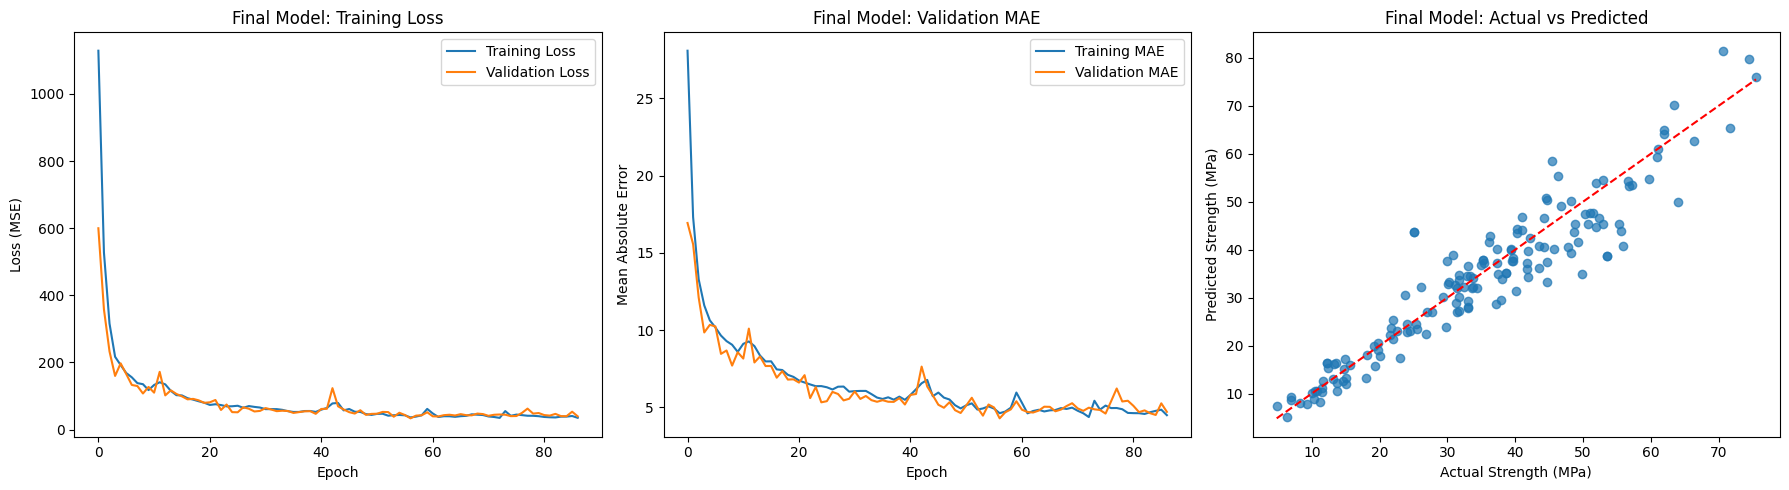

In [16]:
# Plot all three visualizations in a single line
plt.figure(figsize=(18, 5))

# Training and Validation Loss plot
plt.subplot(1, 3, 1)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Training and Validation MAE plot
plt.subplot(1, 3, 2)
plt.plot(final_history.history['mae'], label='Training MAE')
plt.plot(final_history.history['val_mae'], label='Validation MAE')
plt.title('Final Model: Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Predictions vs Actual Values plot
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Final Model: Actual vs Predicted')
plt.xlabel('Actual Strength (MPa)')
plt.ylabel('Predicted Strength (MPa)')

# Add spacing between subplots and save
plt.tight_layout()
plt.show()

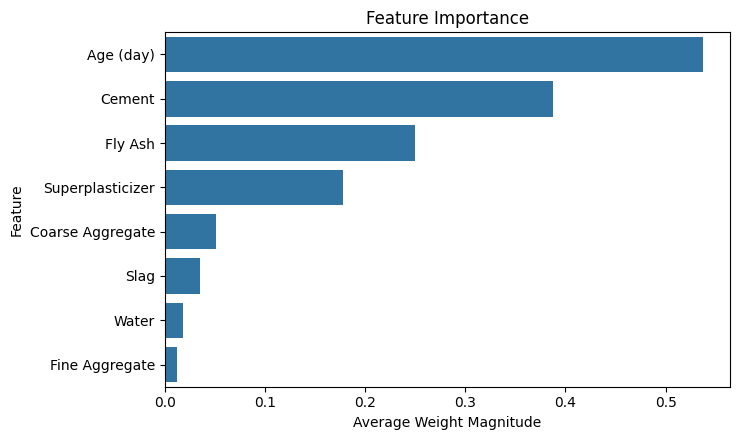

In [17]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Weight': np.abs(final_model.layers[0].get_weights()[0].mean(axis=1))
})
feature_importance = feature_importance.sort_values('Weight', ascending=False)

plt.figure(figsize=(7.5, 4.5))
sns.barplot(x='Weight', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Average Weight Magnitude')
plt.tight_layout()
plt.show()


In [18]:
# Save the best model
final_model.save('concrete_strength_prediction_model.h5')
print("\nModel saved as 'concrete_strength_prediction_model.h5'")

# Print summary of all results for comparison
print("\nModel Comparison Summary:")
print("=" * 80)
print(f"{'Configuration':<40} {'Val MSE':<10} {'Test MSE':<10} {'Test MAE':<10} {'Test R²':<10}")
print("-" * 80)
for i, result in enumerate(model_results):
    config = result['config']
    config_str = f"L:{config['n_layers']} A:{config['activation']} O:{config['optimizer']} LR:{config['lr_schedule']}"
    print(f"{config_str:<40} {result['validation_mse']:<10.4f} {result['test_mse']:<10.4f} {result['test_mae']:<10.4f} {result['test_r2']:<10.4f}")
print("=" * 80)
print(f"Baseline Model {'':<28} {baseline_mse:<10.4f} {baseline_mae:<10.4f} {baseline_r2:<10.4f}")
print(f"Final Model {'':<31} {final_mse:<10.4f} {final_mae:<10.4f} {final_r2:<10.4f}")
print("=" * 80)


Model saved as 'concrete_strength_prediction_model.h5'

Model Comparison Summary:
Configuration                            Val MSE    Test MSE   Test MAE   Test R²   
--------------------------------------------------------------------------------
L:2 A:relu O:adam LR:None                42.5850    27.6515    4.0249     0.8944    
L:3 A:relu O:adam LR:None                30.3533    26.2153    3.9184     0.8999    
L:3 A:tanh O:adam LR:None                38.2711    31.9457    4.0083     0.8780    
L:3 A:relu O:sgd LR:None                 24.2135    25.0089    3.4572     0.9045    
L:3 A:relu O:adam LR:step                49.9816    34.1536    4.3623     0.8696    
L:3 A:relu O:adam LR:cosine              29.0320    30.7424    4.1391     0.8826    
Baseline Model                              30.1271    4.3357     0.8849    
Final Model                                 29.9294    3.9844     0.8857    
